# 第五章 &nbsp; &nbsp; RNN 
到目前为止，我们看到的神经网络都是前馈型神经网络。 **前馈（feedforward）** 是指网络的传播方向是单向的。具体地说，先将输入信号传给下一层（隐藏层），接收到信号的层也同样传给下一层，然后再传给下一层……像这样，信号仅在一个方向上传播。

虽然前馈网络结构简单、易于理解，但是可以应用于许多任务中。不过，这种网络存在一个大问题，就是不能很好地处理时间序列数据（以下简称为“时序数据”）。更确切地说，单纯的前馈网络无法充分学习时序数据的性质（模式）。于是，**RNN（Recurrent Neural Network，循环神经网络）**便应运而生。

本章我们将指出前馈网络的问题，并介绍 RNN 如何很好地解决这些问题。然后，我们会详细解释 RNN 的结构，并用 Python 对其进行实现。

## 概率和语言模型
作为介绍 RNN 的准备，我们将首先复习上一章的 word2vec，然后使用概率描述自然语言相关的现象，最后介绍从概率视角研究语言的“语言模型”。

## 概率视角下的word2vec
我们先复习一下 word2vec 的 CBOW 模型。这里，我们来考虑由单词序列 $w_1, w_2, \cdots, w_T$ 表示的语料库，将第 $t$ 个单词作为目标词，将它左右的（第 $t - 1$ 个和第 $t + 1$ 个）单词作为上下文。

在本书中，目标词是指中间的单词，上下文是指目标词周围的单词。

如图所示，CBOW 模型所做的事情就是从上下文（$w_{t - 1}$ 和 $w_{t + 1}$）预测目标词（$w_t$）。

<img src="./fig/CBOW_word2vec_predict.png" alt="CBOW_word2vec_predict" style="display: block; margin: 0 auto;">

下面，我们用数学式来表示 “当给定 $w_{t - 1}$ 和 $w_{t + 1}$ 时目标词是 $w_t$ 的概率”，如式 (5.1) 所示：

$$P(w_t | w_{t - 1}, w_{t + 1}) \tag{5.1}$$

CBOW 模型对式 (5.1) 这一后验概率进行建模。这个后验概率表示 “当给定 $w_{t - 1}$ 和 $w_{t + 1}$ 时 $w_t$ 发生的概率”。这是窗口大小为 1 时的 CBOW 模型。

顺便提一下，我们之前考虑的窗口都是左右对称的。这里我们将上下文限定为左侧窗口，比如图所示的情况。

<img src="./fig/context_left.png" alt="context_left" style="display: block; margin: 0 auto;">

在仅将左侧 2 个单词作为上下文的情况下，CBOW 模型输出的概率如式 (5.2) 所示：

$$P(w_t | w_{t - 2}, w_{t - 1}) \tag{5.2}$$

word2vec 的上下文窗口大小是超参数，可以设置为任何值。这里将窗口大小设置为左右非对称的形式，即左侧 2 个单词，右侧 0 个单词。这样设定的理由是提前考虑了后面要说的语言模型。

使用式 (5.2) 的写法，CBOW 模型的损失函数可以写成式 (5.3)。式 (5.3) 是从交叉熵误差推导出来的结果。

$$L = -\log P(w_t | w_{t - 2}, w_{t - 1}) \tag{5.3}$$

CBOW 模型的学习旨在找到使式 (5.3) 表示的损失函数（确切地说，是整个语料库的损失函数之和）最小的权重参数。只要找到了这样的权重参数，CBOW 模型就可以更准确地从上下文预测目标词。

像这样，CBOW 模型的学习目的是从上下文预测出目标词。为了达成这一目标，随着学习的推进，（作为副产品）获得了编码了单词含义信息的单词的分布式表示。

那么，CBOW 模型本来的目的 “从上下文预测目标词” 是否可以用来做些什么呢？式 (5.2) 表示的概率 $P(w_t | w_{t - 2}, w_{t - 1})$ 是否可以在一些实际场景中发挥作用呢？说到这里，就要提一下语言模型了。

###  语言模型
**语言模型（language model）** 给出了单词序列发生的概率。具体来说，就是使用概率来评估一个单词序列发生的可能性，即在多大程度上是自然的单词序列。比如，对于 “you say goodbye” 这一单词序列，语言模型给出高概率（比如 0.092）；对于 “you say good die” 这一单词序列，模型则给出低概率（比如 0.000 000 000 003 2）。

语言模型可以应用于多种应用，典型的例子有机器翻译和语音识别。比如，语音识别系统会根据人的发言生成多个句子作为候选。此时，使用语言模型，可以按照 “作为句子是否自然” 这一基准对候选句子进行排序。

语言模型也可以用于生成新的句子。因为语言模型可以使用概率来评价单词序列的自然程度，所以它可以根据这一概率分布造出（采样）单词。另外，第 7 章中我们会讨论如何使用语言模型生成文章。

现在，我们使用数学式来表示语言模型。这里考虑由 $m$ 个单词 $w_1, \cdots, w_m$ 构成的句子，将单词按 $w_1, \cdots, w_m$ 的顺序出现的概率记为 $P(w_1, \cdots, w_m)$。因为这个概率是多个事件一起发生的概率，所以称为**联合概率**。

使用后验概率可以将这个联合概率 $P(w_1, \cdots, w_m)$ 分解成如下形式：

$$
\begin{align*}
P(w_1, \cdots, w_m) &= P(w_m | w_1, \cdots, w_{m - 1})P(w_{m - 1} | w_1, \cdots, w_{m - 2}) \\
&\quad \cdots P(w_3 | w_1, w_2)P(w_2 | w_1)P(w_1) \\
&= \prod_{t = 1}^{m} P(w_t | w_1, \cdots, w_{t - 1}) \tag{5.4}
\end{align*}
$$

与表示总和的 $\sum$（sigma）相对，式 (5.4) 中的 $\prod$（pi）表示所有元素相乘的乘积。如式 (5.4) 所示，联合概率可以由后验概率的乘积表示。

式 (5.4) 的结果可以从概率的**乘法定理**推导出来。这里我们花一点时间来说明一下乘法定理，并看一下式 (5.4) 的推导过程。

首先，概率的乘法定理可由下式表示：

$$P(A,B) = P(A|B)P(B) \tag{5.5}$$

式 (5.5) 表示的乘法定理是概率论中最重要的定理，意思是 “$A$ 和 $B$ 两个事件共同发生的概率 $P(A,B)$” 是 “$B$ 发生的概率 $P(B)$” 和 “$B$ 发生后 $A$ 发生的概率 $P(A|B)$” 的乘积（这个解释感觉上非常自然）。

概率 $P(A,B)$ 也可以分解为 $P(A,B) = P(B|A)P(A)$。也就是说，根据将 $A$ 和 $B$ 中的哪一个作为后验概率的条件，存在 $P(A,B) = P(B|A)P(A)$ 和 $P(A,B) = P(A|B)P(B)$ 两种表示方法。

使用这个乘法定理，$m$ 个单词的联合概率 $P(w_1, \cdots, w_m)$ 就可以用后验概率来表示。为了便于理解，我们先将式子如下变形：

$$\underbrace{P(w_1, \cdots, w_{m - 1}, w_m)}_{A} = P(A, w_m) = P(w_m|A)P(A) \tag{5.6}$$

这里，将 $w_1, \cdots, w_{m - 1}$ 整体表示为 $A$。这样一来，按照乘法定理，可以推导出式 (5.6)。接着，再对 $A(w_1, \cdots, w_{m - 1})$ 进行同样的变形：

$$P(A) = \underbrace{P(w_1, \cdots, w_{m - 2}, w_{m - 1})}_{A'} = P(A', w_{m - 1}) = P(w_{m - 1}|A')P(A') \tag{5.7}$$

像这样，单词序列每次减少一个，分解为后验概率。然后，重复这一过程，就可以推导出式 (5.4)。

如式 (5.4) 所示，联合概率 $P(w_1, \cdots, w_m)$ 可以表示为后验概率的乘积 $\prod P(w_t|w_1, \cdots, w_{t - 1})$。这里需要注意的是，这个后验概率是以目标词左侧的全部单词为上下文（条件）时的概率，如下图所示。

<img src="./fig/language_model_possibility.png" alt="language_model_possibility" style="display: block; margin: 0 auto;">

这里我们来总结一下，我们的目标是求 $P(w_t|w_1, \cdots, w_{t - 1})$ 这个概率。如果能计算出这个概率，就能求得语言模型的联合概率 $P(w_1, \cdots, w_m)$。

由 $P(w_t|w_1, \cdots, w_{t - 1})$ 表示的模型称为条件语言模型（conditional language model），有时也将其称为语言模型。

### 将CBOW模型用作语言模型？
那么，如果要把 word2vec 的 CBOW 模型（强行）用作语言模型，该怎么办呢？可以通过将上下文的大小限制在某个值来近似实现，用数学式可以如下表示：

$$P(w_1, \cdots, w_m) = \prod_{t = 1}^{m} P(w_t|w_1, \cdots, w_{t - 1}) \approx \prod_{t = 1}^{m} P(w_t|w_{t - 2}, w_{t - 1}) \tag{5.8}$$

这里，我们将上下文限定为左侧的 2 个单词。如此一来，就可以用 CBOW 模型（CBOW 模型的后验概率）近似表示。

在机器学习和统计学领域，经常会听到 “马尔可夫性”（或者 “马尔可夫模型”“马尔可夫链”）这个词。马尔可夫性是指未来的状态仅依存于当前状态。此外，当某个事件的概率仅取决于其前面的 $N$ 个事件时，称为 “$N$ 阶马尔可夫链”。这里展示的是下一个单词仅取决于前面 2 个单词的模型，因此可以称为 “2 阶马尔可夫链”。

式 (5.8) 是使用 2 个单词作为上下文的例子，但是这个上下文的大小可以设定为任意长度（比如 5 或 10）。不过，虽说可以设定为任意长度，但必须是某个“固定”长度。比如，即便是使用左侧 10 个单词作为上下文的 CBOW 模型，其上下文更左侧的单词的信息也会被忽略，而这会导致问题，如图中的例子所示。

<img src="./fig/long_context_example.png" alt="long_context_example" style="display: block; margin: 0 auto;">

在上图的问题中，“Tom 在房间看电视，Mary 进了房间”。根据该语境（上下文），正确答案应该是 Mary 向 Tom（或者 “him”）打招呼。这里要获得正确答案，就必须将 “?” 前面第 18 个单词处的 Tom 记住。如果 CBOW 模型的上下文大小是 10，则这个问题将无法被正确回答。

那么，是否可以通过增大 CBOW 模型的上下文大小（比如变为 20 或 30）来解决此问题呢？的确，CBOW 模型的上下文大小可以任意设定，但是 CBOW 模型还存在忽视了上下文中单词顺序的问题。

CBOW是 Continuous Bag-Of-Words 的简称。Bag-Of-Words 是 “一袋子单词” 的意思，这意味着袋子中单词的顺序被忽视了。

关于上下文的单词顺序被忽视这个问题，我们举个例子来具体说明。比如，在上下文是 2 个单词的情况下，CBOW 模型的中间层是那 2 个单词向量的和，如图所示。

<img src="./fig/CBOW_compared.png" alt="CBOW_compared" style="display: block; margin: 0 auto;">

如上图的左图所示，在 CBOW 模型的中间层求单词向量的和，因此上下文的单词顺序会被忽视。比如，(you, say) 和 (say, you) 会被作为相同的内容进行处理。

我们想要的是考虑了上下文中单词顺序的模型。为此，可以像图 5-5 中的右图那样，在中间层 “拼接”（concatenate）上下文的单词向量。实际上，“Neural Probabilistic Language Model”中提出的模型就采用了这个方法。但是，如果采用拼接的方法，权重参数的数量将与上下文大小成比例地增加。显然，这是我们不愿意看到的。

那么，如何解决这里提出的问题呢？这就轮到 RNN 出场了。RNN 具有一个机制，那就是无论上下文有多长，都能将上下文信息记住。因此，使用 RNN 可以处理任意长度的时序数据。下面，我们就来感受一下 RNN 的魅力。

word2vec 是以获取单词的分布式表示为目的的方法，因此一般不会用于语言模型。这里，为了引出 RNN 的魅力，我们拓展了话题，强行将 word2vec 的 CBOW 模型应用在了语言模型上。word2vec 和基于 RNN 的语言模型是由托马斯・米科洛夫团队分别在 2013 年和 2010 年提出的。基于 RNN 的语言模型虽然也能获得单词的分布式表示，但是为了应对词汇量的增加、提高分布式表示的质量，word2vec 被提了出来。

## RNN
RNN（Recurrent Neural Network）中的 Recurrent 源自拉丁语，意思是“反复发生”，可以翻译为“重复发生”“周期性地发生”“循环”，因此 RNN 可以直译为“复发神经网络”或者“循环神经网络”。下面，我们将探讨“循环”一词。

Recurrent Neural Network 通常译为“循环神经网络”。另外，还有一种被称为 Recursive Neural Network（递归神经网络）的网络。这个网络主要用于处理树结构的数据，和循环神经网络不是一个东西。

## 循环的神经网络
“循环”是什么意思呢？是“反复并持续”的意思。从某个地点出发，经过一定时间又回到这个地点，然后重复进行，这就是“循环”一词的含义。这里要注意的是，循环需要一个“环路”。

只有存在了“环路”或者“回路”这样的路径，媒介（或者数据）才能在相同的地点之间来回移动。随着数据的循环，信息不断被更新。

血液在我们体内循环。今天流动的血液是接着昨天的血液继续流动的。另外，它也是接着一周前的、一个月前的、一年前的，甚至刚出生时的血液继续流动的。血液通过在体内循环，从过去一直被“更新”到现在。

RNN 的特征就在于拥有这样一个环路（或回路）。这个环路可以使数据不断循环。通过数据的循环，RNN 一边记住过去的数据，一边更新到最新的数据。

下面，我们来具体地看一下 RNN。这里，我们将 RNN 中使用的层称为“RNN 层”，如图所示。

<img src="./fig/RNN_layer.png" alt="RNN_layer" style="display: block; margin: 0 auto;">

如图所示，RNN 层有环路。通过该环路，数据可以在层内循环。在图中，时刻 $t$ 的输入是 $\boldsymbol{x}_t$，这暗示着时序数据 $(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots, \boldsymbol{x}_t, \cdots)$ 会被输入到层中。然后，以与输入对应的形式，输出 $(\boldsymbol{h}_0, \boldsymbol{h}_1, \cdots, \boldsymbol{h}_t, \cdots)$。

这里假定在各时刻向 RNN 层输入的 $\boldsymbol{x}_t$ 是向量。比如，在处理句子（单词序列）的情况下，将各个单词的分布式表示（单词向量）作为 $\boldsymbol{x}_t$ 输入 RNN 层。

仔细看一下上图，可以发现输出有两个分叉，这意味着同一个东西被复制了。输出中的一个分叉将成为其自身的输入。

接着，我们来详细介绍一下循环结构。在此之前，我们先将 RNN 层的绘制方法更改如下。

如下图所示，到目前为止，我们在绘制层时都是假设数据从左向右流动的。不过，从现在开始，为了节省纸面空间，我们将假设数据是从下向上流动的（这是为了在之后需要展开循环时，能够在左右方向上将层铺开）。

<img src="./fig/RNN_layer_spin.png" alt="RNN_layer_spin" style="display: block; margin: 0 auto;">

###  展开循环
现在，准备工作已经完成了，我们来仔细看一下 RNN 层的循环结构。RNN 的循环结构在之前的神经网络中从未出现过，但是通过展开循环，可以将其转化为我们熟悉的神经网络。百闻不如一见，现在我们就实际地进行展开。

<img src="./fig/RNN_layer_unfold.png" alt="RNN_layer_unfold" style="display: block; margin: 0 auto;">

如图所示，通过展开 RNN 层的循环，我们将其转化为了从左向右延伸的长神经网络。这和我们之前看到的前馈神经网络的结构相同（前馈网络的数据只向一个方向传播）。不过，图中的多个 RNN 层都是“**同一个层**”，这一点与之前的神经网络是不一样的。

时序数据按时间顺序排列。因此，我们用“时刻”这个词指代时序数据的索引（比如，时刻$t$的输入数据为$\boldsymbol{x}_t$）。在自然语言处理的情况下，既使用“第$t$个单词”“第$t$个RNN层”这样的表述，也使用“时刻$t$的单词”或者“时刻$t$的RNN层”这样的表述。

由上图可以看出，各个时刻的 RNN 层接收传给该层的输入和前一个 RNN 层的输出，然后据此计算当前时刻的输出，此时进行的计算可以用下式表示：

$$\boldsymbol{h}_t = \tanh(\boldsymbol{h}_{t - 1}\boldsymbol{W}_h + \boldsymbol{x}_t\boldsymbol{W}_x + \boldsymbol{b}) \tag{5.9}$$

首先说明一下式 (5.9) 中的符号。RNN 有两个权重，分别是将输入 $\boldsymbol{x}$ 转化为输出 $\boldsymbol{h}$ 的权重 $\boldsymbol{W}_x$ 和将前一个 RNN 层的输出转化为当前时刻的输出的权重 $\boldsymbol{W}_h$。此外，还有偏置 $\boldsymbol{b}$。这里，$\boldsymbol{h}_{t - 1}$ 和 $\boldsymbol{x}_t$ 都是行向量。

在式 (5.9) 中，首先执行矩阵的乘积计算，然后使用 $\tanh$ 函数（双曲正切函数）变换它们的和，其结果就是时刻 $t$ 的输出 $\boldsymbol{h}_t$。这个 $\boldsymbol{h}_t$ 一方面向上输出到另一个层，另一方面向右输出到下一个 RNN 层（自身）。

观察式 (5.9) 可以看出，现在的输出 $\boldsymbol{h}_t$ 是由前一个输出 $\boldsymbol{h}_{t - 1}$ 计算出来的。从另一个角度看，这可以解释为，RNN 具有 “状态” $\boldsymbol{h}$，并以式 (5.9) 的形式被更新。这就是说 RNN 层是 “具有状态的层” 或 “具有存储（记忆）的层” 的原因。

RNN 的 $\boldsymbol{h}$ 存储“状态”，时间每前进一步（一个单位），它就以式 (5.9) 的形式被更新。许多文献中将 RNN 的输出 $\boldsymbol{h}_t$ 称为隐藏状态（hidden state）或隐藏状态向量（hidden state vector），本书中也是如此。

另外，许多文献中将展开后的 RNN 层绘制成下图的左图。

<img src="./fig/RNN_layer_compared.png" alt="RNN_layer_compared" style="display: block; margin: 0 auto;">

在左图中，从 RNN 层输出了两个箭头，但是请注意这两个箭头代表的是同一份数据（准确地说，是同一份数据被复制了）。在本书中，和之前一样，我们明确地在图中显示了输出处存在分叉，如右图所示。


## Backpropagation Through Time
将 RNN 层展开后，就可以视为在水平方向上延伸的神经网络，因此 RNN 的学习可以用与普通神经网络的学习相同的方式进行，如图所示。

<img src="./fig/RNN_backpropagation.png" alt="RNN_backpropagation" style="display: block; margin: 0 auto;">

如图所示，将循环展开后的 RNN 可以使用（常规的）误差反向传播法。换句话说，可以通过先进行正向传播，再进行反向传播的方式求目标梯度。因为这里的误差反向传播法是 “按时间顺序展开的神经网络的误差反向传播法”，所以称为 **Backpropagation Through Time**（基于时间的反向传播），简称 BPTT。

通过该 BPTT，RNN 的学习似乎可以进行了，但是在这之前还有一个必须解决的问题，那就是学习长时序数据的问题。因为随着时序数据的时间跨度的增大，BPTT 消耗的计算机资源也会成比例地增大。另外，反向传播的梯度也会变得不稳定。

要基于 BPTT 求梯度，必须在内存中保存各个时刻的 RNN 层的中间数据（RNN 层的反向传播将在后文中说明）。因此，随着时序数据变长，计算机的内存使用量（不仅仅是计算量）也会增加。

## Truncated BPTT
在处理长时序数据时，通常的做法是将网络连接截成适当的长度。具体来说，就是将时间轴方向上过长的网络在合适的位置进行截断，从而创建多个小型网络，然后对截出来的小型网络执行误差反向传播法，这个方法称为 **Truncated BPTT**（截断的 BPTT）。

Truncated 是“被截断”的意思。Truncated BPTT 是指按适当长度截断的误差反向传播法。

在 Truncated BPTT 中，网络连接被截断，但严格地讲，只是网络的反向传播的连接被截断，正向传播的连接依然被维持，这一点很重要。也就是说，正向传播的信息没有中断地传播。与此相对，反向传播则被截断为适当的长度，以被截出的网络为单位进行学习。

现在，我们结合具体的例子来介绍 Truncated BPTT。假设有一个长度为 1000 的时序数据。在自然语言处理的情况下，这相当于一个有 1000 个单词的语料库。顺便说一下，我们之前处理的 PTB 数据集将多个串联起来的句子当作一个大的时序数据。这里也一样，将多个串联起来的句子当作一个时序数据。

在处理长度为 1000 的时序数据时，如果展开 RNN 层，它将成为在水平方向上排列有 1000 个层的网络。当然，无论排列多少层，都可以根据误差反向传播法计算梯度。但是，如果序列太长，就会出现计算量或者内存使用量方面的问题。此外，随着层变长，梯度逐渐变小，梯度将无法向前一层传递。因此，如图所示，我们来考虑在水平方向上以适当的长度截断网络的反向传播的连接。

------

在自然语言处理（NLP）中，将“多个串联起来的句子当作一个大的时序数据”是一种常见的数据处理方式，目的是为了更高效地训练循环神经网络（RNN）或Transformer等模型，尤其与Truncated BPTT（截断的时间反向传播）的训练方式相适配。


### 具体含义：把句子“连起来”形成长序列
假设我们有3个独立的句子：
1. "I like machine learning."
2. "It is interesting and useful."
3. "I want to learn more."

在NLP中，我们会先将每个句子拆分为单词（或子词）的序列，再添加特殊标记（如句尾标记`<eos>`），最后把它们**首尾拼接**成一个连续的长序列：

```
["I", "like", "machine", "learning", "<eos>", 
 "It", "is", "interesting", "and", "useful", "<eos>", 
 "I", "want", "to", "learn", "more", "<eos>"]
```

这个拼接后的长序列就被视为一个**单一的时序数据**，其中每个单词（包括`<eos>`）是时序数据中的一个“时间步”。当处理类似PTB（Penn Treebank）这样的语料库时，整个数据集会被拼接成一个极长的时序序列（可能包含数万甚至数十万个单词）。


### 为什么要这样做？
1. **适配RNN的“时序连续性”**  
   RNN的核心能力是处理时序依赖关系（如“上下文语义”），而句子之间往往存在潜在的语义关联（例如篇章中的逻辑衔接）。将句子拼接成连续序列，能让模型学习到更广泛的上下文依赖，而不仅仅是单个句子内部的关系。

2. **提高训练效率**  
   若单独处理每个句子，句子长度通常较短（比如平均20-30个单词），训练时需要频繁处理“句子开始/结束”的边界，效率较低。拼接成大序列后，可以更充分地利用计算资源（如GPU的并行计算能力）。

3. **配合Truncated BPTT的训练需求**  
   Truncated BPTT的核心是将超长时序数据**分段截断**后训练（例如将1000步的长序列分成10段，每段100步）。如果原始数据是分散的短句子，截断后可能频繁出现“跨句子”的无效截断；而拼接成大序列后，截断可以更灵活地在连续的时序中进行，减少边界干扰。


### 与Truncated BPTT的结合示例
假设我们有一个拼接后的长时序数据（长度1000，即1000个单词）：

```
[w1, w2, ..., w100, w101, ..., w200, ..., w901, ..., w1000]
```

Truncated BPTT的处理方式是：
1. 将长序列**按固定长度截断**（如每100步为一段），得到10个分段：`[w1-w100], [w101-w200], ..., [w901-w1000]`。
2. 对每个分段独立计算前向传播和反向传播（只在分段内部更新梯度），避免了原始BPTT处理1000步时的梯度消失/爆炸问题。
3. 由于原始数据是连续拼接的，相邻分段（如`w1-w100`和`w101-w200`）在语义上仍有连续性，模型通过“隐藏状态传递”（保留上一分段的最终隐藏状态作为下一分段的初始状态），仍能学到跨分段的时序依赖。


### 关键总结
“将多个句子串联成大的时序数据”本质上是一种**数据整合策略**，它：
- 让模型能学习更广泛的上下文依赖（从句子内扩展到句子间）；
- 与Truncated BPTT的“分段截断”训练方式完美适配，既解决了RNN训练的梯度问题，又保留了时序连续性；
- 是PTB等经典语料库的标准处理方式，也是早期RNN/LSTM在NLP中成功应用的重要基础。

-----

<img src="./fig/RNN_cut_off.png" alt="RNN_cut_off" style="display: block; margin: 0 auto;">

在图中，我们截断了反向传播的连接，以使学习可以以 10 个 RNN 层为单位进行。像这样，只要将反向传播的连接截断，就不需要再考虑块范围以外的数据了，因此可以以各个块为单位（和其他块没有关联）完成误差反向传播法。

这里需要注意的是，虽然反向传播的连接会被截断，但是正向传播的连接不会。因此，在进行 RNN 的学习时，必须考虑到正向传播之间是有关联的，这意味着必须按顺序输入数据。下面，我们来说明什么是按顺序输入数据。

我们之前看到的神经网络在进行 mini-batch 学习时，数据都是随机选择的。但是，在 RNN 执行 Truncated BPTT 时，数据需要按顺序输入。

现在，我们考虑使用 Truncated BPTT 来学习 RNN。我们首先要做的是，将第 1 个块的输入数据 $(\boldsymbol{x}_0, \cdots, \boldsymbol{x}_9)$ 输入 RNN 层。这里要进行的处理如下图所示。

<img src="./fig/propagation_cut_off.png" alt="propagation_cut_off" style="display: block; margin: 0 auto;">

如图所示，先进行正向传播，再进行反向传播，这样可以得到所需的梯度。接着，对下一个块的输入数据 $(\boldsymbol{x}_{10}, \boldsymbol{x}_{11}, \cdots, \boldsymbol{x}_{19})$ 执行误差反向传播法，如下图所示。

<img src="./fig/two_propagation.png" alt="two_propagation" style="display: block; margin: 0 auto;">

这里，和第 1 个块一样，先执行正向传播，再执行反向传播。这里的重点是，这个正向传播的计算需要前一个块最后的隐藏状态 $\boldsymbol{h}_9$，这样可以维持正向传播的连接。

用同样的方法，继续学习第 3 个块，此时要使用第 2 个块最后的隐藏状态 $\boldsymbol{h}_{19}$。像这样，在 RNN 的学习中，通过将数据按顺序输入，从而继承隐藏状态进行学习。根据到目前为止的讨论，可知 RNN 的学习流程如下图所示。

<img src="./fig/Truncated_BPTT_example.png" alt="Truncated_BPTT_example" style="display: block; margin: 0 auto;">

如图所示，Truncated BPTT 按顺序输入数据，进行学习。这样一来，能够在维持正向传播的连接的同时，以块为单位应用误差反向传播法。

## Truncated BPTT的mini-batch学习
到目前为止，我们在探讨 Truncated BPTT 时，并没有考虑 mini-batch 学习。换句话说，我们之前的探讨对应于批大小为 1 的情况。为了执行 mini-batch 学习，需要考虑批数据，让它也能像上图一样按顺序输入数据。因此，在输入数据的开始位置，需要在各个批次中进行 “偏移”。

为了说明 “偏移”，我们仍用上一节的通过 Truncated BPTT 进行学习的例子，对长度为 1000 的时序数据，以时间长度 10 为单位进行截断。此时，如何将批大小设为 2 进行学习呢？在这种情况下，作为 RNN 层的输入数据，第 1 笔样本数据从头开始按顺序输入，第 2 笔数据从第 500 个数据开始按顺序输入。也就是说，将开始位置平移 500，如下图所示。

<img src="./fig/mini_batch.png" alt="mini_batch" style="display: block; margin: 0 auto;">

如图所示，批次的第 1 个元素是 $\boldsymbol{x}_0, \cdots, \boldsymbol{x}_9$，批次的第 2 个元素是 $\boldsymbol{x}_{500}, \cdots, \boldsymbol{x}_{509}$，将这个 mini-batch 作为 RNN 的输入数据进行学习。因为要输入的数据是按顺序的，所以接下来是时序数据的第 10～19 个数据和第 510～519 个数据。像这样，在进行 mini-batch 学习时，平移各批次输入数据的开始位置，按顺序输入。此外，如果在按顺序输入数据的过程中遇到了结尾，则需要设法返回头部。

如上所述，虽然 Truncated BPTT 的原理非常简单，但是关于数据的输入方法有几个需要注意的地方。具体而言，一是要按顺序输入数据，二是要平移各批次（各样本）输入数据的开始位置。这里的探讨有些复杂，大家一时间可能还不能理解，之后通过实际查看和运行代码，相信大家就能够理解了。


## RNN的实现
通过之前的探讨，我们已经看到了 RNN 的全貌。实际上，我们要实现的是一个在水平方向上延伸的神经网络。另外，考虑到基于 Truncated BPTT 的学习，只需要创建一个在水平方向上长度固定的网络序列即可，如图所示。

<img src="./fig/RNN_network.png" alt="RNN_network" style="display: block; margin: 0 auto;">

如图所示，目标神经网络接收长度为 $T$ 的时序数据（$T$ 为任意值），输出各个时刻的隐藏状态 $T$ 个。这里，考虑到模块化，将图中在水平方向上延伸的神经网络实现为“一个层”，如下图所示。

<img src="./fig/RNN_time.png" alt="RNN_time" style="display: block; margin: 0 auto;">

如图所示，将垂直方向上的输入和输出分别捆绑在一起，就可以将水平排列的层视为一个层。换句话说，可以将 $(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots, \boldsymbol{x}_{T - 1})$ 捆绑为 $\boldsymbol{x}s$ 作为输入，将 $(\boldsymbol{h}_0, \boldsymbol{h}_1, \cdots, \boldsymbol{h}_{T - 1})$ 捆绑为 $\boldsymbol{h}s$ 作为输出。这里，我们将进行 Time RNN 层中的单步处理的层称为“RNN 层”，将一次处理 $T$ 步的层称为“Time RNN 层”。

像 Time RNN 这样，将整体处理时序数据的层以单词“Time”开头命名，这是本书中规定的命名规范。之后，我们还会实现 Time Affine 层、Time Embedding 层等。

我们接下来进行的实现的流程是：首先，实现进行 RNN 单步处理的 RNN 类；然后，利用这个 RNN 类，完成一次进行 $T$ 步处理的 ``TimeRNN`` 类。

### RNN层的实现
现在，我们来实现进行 RNN 单步处理的 RNN 类。首先复习一下 RNN 正向传播的数学式，如式 (5.10) 所示：

$$\boldsymbol{h}_t = \tanh(\boldsymbol{h}_{t - 1}\boldsymbol{W}_h + \boldsymbol{x}_t\boldsymbol{W}_x + \boldsymbol{b}) \tag{5.10}$$

这里，我们将数据整理为 mini-batch 进行处理。因此，$\boldsymbol{x}_t$（和 $\boldsymbol{h}_t$）在行方向上保存各样本数据。在矩阵计算中，矩阵的形状检查非常重要。这里，假设批大小是 $N$，输入向量的维数是 $D$，隐藏状态向量的维数是 $H$，则矩阵的形状检查可以像下面这样进行。

<img src="./fig/matrix_check.png" alt="matrix_check" style="display: block; margin: 0 auto;">

如图所示，通过矩阵的形状检查，可以确认它的实现是否正确，至少可以确认它的计算是否成立。基于以上内容，现在我们给出 RNN 类的初始化方法和正向传播的 `forward()` 方法。

In [1]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]  # 输入权重，隐藏状态权重，偏置
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] 
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params 
        t = np.dot(x, Wx) + np.dot(h_prev, Wh) + b # 计算当前时刻的隐状态
        t_next = np.tanh(t) # 激活函数

        self.cache = (x, h_prev, t_next) # 缓存前向传播需要的变量
        return t_next


RNN 的初始化方法接收两个权重参数和一个偏置参数。这里，将通过函数参数传进来的模型参数设置为列表类型的成员变量 `params`。然后，以各个参数对应的形状初始化梯度，并保存在 `grads` 中。最后，使用 `None` 对反向传播时要用到的中间数据 `cache` 进行初始化。

正向传播的 `forward(x, h_prev)` 方法接收两个参数：从下方输入的 `x` 和从左边输入的 `h_prev`。剩下的就是按式 (5.10) 进行实现。顺便说一下，这里从前一个 RNN 层接收的输入是 `h_prev`，当前时刻的 RNN 层的输出（= 下一时刻的 RNN 层的输入）是 `h_next`。

接下来，我们继续实现 RNN 的反向传播。在此之前，让我们通过下图的计算图再次确认一下 RNN 的正向传播。

<img src="./fig/RNN_calculation.png" alt="RNN_calculation" style="display: block; margin: 0 auto;">

RNN 层的正向传播可由上图的计算图表示。这里进行的计算由矩阵乘积 “MatMul”、加法 “+” 和 “tanh” 这 3 种运算构成。此外，因为偏置 $\boldsymbol{b}$ 的加法运算会触发广播操作，所以严格地讲，这里还应该加上 Repeat 节点。不过简单起见，这里省略了它。

那么，上图的计算图的反向传播是什么样的呢？答案很简单。因为这 3 种运算的反向传播我们都已经掌握了（关于反向传播，请参考第一章内容），剩下就是基于下图，按正向传播的反方向实现各个运算的反向传播。

<img src="./fig/RNN_backpropagation_calculation.png" alt="RNN_backpropagation_calculation" style="display: block; margin: 0 auto;">

下面实现 RNN 层的 ``backward()``。参考上图，可以如下实现。

In [2]:
def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, t_next = self.cache

    dt = (1 - t_next ** 2) * dh_next # tanh的导数，维度为 (N, H)
    db = np.sum(dt, axis=0) # 偏置梯度，维度为 (H,)
    dWh = np.dot(h_prev.T, dt) # 隐状态权重梯度，维度为 (H, H)
    dh_prev = np.dot(dt, Wh.T) # 上一时刻隐状态梯度，维度为 (N, H)
    dWx = np.dot(x.T, dt) # 输入权重梯度，维度为 (D, H)
    dx = np.dot(dt, Wx.T) # 输入数据梯度，维度为 (N, D)

    self.grads[0][...] = dWx # 更新梯度
    self.grads[1][...] = dWh # 更新梯度
    self.grads[2][...] = db # 更新梯度

    return dx, dh_prev

## Time RNN层的实现
Time RNN 层由 $T$ 个 RNN 层构成（$T$ 可以设置为任意值），如下图所示。

<img src="./fig/time_RNN_vs_RNN.png" alt="time_RNN_vs_RNN" style="display: block; margin: 0 auto;">

由图可知，Time RNN 层是 $T$ 个 RNN 层连接起来的网络。我们将这个网络实现为 Time RNN 层。这里，RNN 层的隐藏状态 $\boldsymbol{h}$ 保存在成员变量中。如下图所示，在进行隐藏状态的 “继承” 时会用到它。

<img src="./fig/time_RNN_h.png" alt="time_RNN_h" style="display: block; margin: 0 auto;">

如图所示，我们使用 Time RNN 层管理 RNN 层的隐藏状态。这样一来，使用 Time RNN 的人就不必考虑 RNN 层的隐藏状态的“继承工作”了。另外，我们可以用 `stateful` 这个参数来控制是否继承隐藏状态。

下面，我们来看一下 Time RNN 层的实现。首先实现初始化方法和两个方法（`common/time_layers.py`）。

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False): # stateful表示是否保持状态
        self.params = [Wx, Wh, b] # 输入权重，隐藏状态权重，偏置
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] 
        self.layers = None # RNN层列表
        self.h, self.dh = None, None # 隐状态和梯度
        self.stateful = stateful # 是否保持状态

    def set_state(self, h):
        self.h = h # 设置隐状态

    def reset_state(self):
        self.h = None # 重置隐状态

初始化方法的参数有权重、偏置和布尔型（True/False）的 `stateful`。一个成员变量 `layers` 在列表中保存多个 RNN 层，另一个成员变量 `h` 保存调用 `forward()` 方法时的最后一个 RNN 层的隐藏状态。另外，在调用 `backward()` 时，`dh` 保存传给前一个块的隐藏状态的梯度（关于 `dh`，我们会在反向传播的实现中说明）。

考虑到 TimeRNN 类的扩展性，将设定 Time RNN 层的隐藏状态的方法实现为 <code>set_state(h)</code>。另外，将重置隐藏状态的方法实现为 <code>reset_state()</code>。

上述参数中的 `stateful` 是“有状态”的意思。在本书的实现中，当 `stateful` 为 `True` 时，Time RNN 层“有状态”。这里说的“有状态”是指维持 Time RNN 层的隐藏状态。也就是说，无论时序数据多长，Time RNN 层的正向传播都可以不中断地进行。而当 `stateful` 为 `False` 时，每次调用 Time RNN 层的 `forward()` 时，第一个 RNN 层的隐藏状态都会被初始化为零矩阵（所有元素均为 0 的矩阵）。这是没有状态的模式，称为“无状态”。

在处理长时序数据时，需要维持 RNN 的隐藏状态，这一功能通常用“stateful”一词表示。在许多深度学习框架中，RNN 层都有 stateful 参数，该参数用于指定是否保存上一时刻的隐藏状态。

接着，我们来看一下正向传播的实现。

In [4]:
def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape # 输入数据的形状 (批量大小，时间步数，输入维度)
    H = Wh.shape[0] # 隐状态维度

    self.layers = [] # 初始化RNN层列表
    hs = np.empty((N, T, H), dtype='f') # 初始化输出隐藏状态

    if not self.stateful or self.h is None:
        self.h = np.zeros((N, H), dtype='f') # 初始化隐状态

    for t in range(T):
        layer = RNN(*self.params) # 创建RNN层，传入权重和偏置
        self.h = layer.forward(xs[:, t, :], self.h) # 前向传播
        hs[:, t, :] = self.h # 保存当前时刻的隐状态
        self.layers.append(layer) # 保存RNN层

    return hs

正向传播的 `forward(xs)` 方法从下方获取输入 `xs`，`xs` 囊括了 $T$ 个时序数据。因此，如果批大小是 $N$，输入向量的维数是 $D$，则 `xs` 的形状为 $(N, T, D)$。

在首次调用时（`self.h` 为 `None` 时），RNN 层的隐藏状态 $\boldsymbol{h}$ 由所有元素均为 0 的矩阵初始化。另外，在成员变量 `stateful` 为 `False` 的情况下，$\boldsymbol{h}$ 将总是被重置为零矩阵。

在主体实现中，首先通过 `hs=np.empty((N, T, H), dtype='f')` 为输出准备一个“容器”。接着，在 $T$ 次 `for` 循环中，生成 RNN 层，并将其添加到成员变量 `layers` 中。然后，计算 RNN 层各个时刻的隐藏状态，并存放在 `hs` 的对应索引（时刻）中。

如果调用 Time RNN 层的 <code>forward()</code> 方法，则成员变量 <code>h</code> 中将存放最后一个 RNN 层的隐藏状态。在 <code>stateful</code> 为 <code>True</code> 的情况下，在下一次调用 <code>forward()</code> 方法时，刚才的成员变量 <code>h</code> 将被继续使用。而在 <code>stateful</code> 为 <code>False</code> 的情况下，成员变量 <code>h</code> 将被重置为零向量。

接下来是 Time RNN 层的反向传播的实现。用计算图绘制这个反向传播，如下图所示。

<img src="./fig/time_RNN_backpropagation.png" alt="time_RNN_backpropagation" style="display: block; margin: 0 auto;">

在图中，将从上游（输出侧的层）传来的梯度记为 $\boldsymbol{dh}s$，将流向下游的梯度记为 $\boldsymbol{dx}s$。因为这里我们进行的是 Truncated BPTT，所以不需要流向这个块上一时刻的反向传播。不过，我们将流向上一时刻的隐藏状态的梯度存放在成员变量 $\boldsymbol{dh}$ 中。这是因为在第 7 章探讨 seq2seq（sequence-to-sequence，序列到序列）时会用到它（具体请参考第 7 章）。

以上就是 Time RNN 层的反向传播的全貌图。如果关注第 $t$ 个 RNN 层，则它的反向传播如图所示。

<img src="./fig/RNN_propagation_t.png" alt="RNN_propagation_t" style="display: block; margin: 0 auto;">

从上方传来的梯度 $\boldsymbol{dh}_t$ 和从将来的层传来的梯度 $\boldsymbol{dh}_{\text{next}}$ 会传到第 $t$ 个 RNN 层。这里需要注意的是，RNN 层的正向传播的输出有两个分叉。在正向传播存在分叉的情况下，在反向传播时各梯度将被求和。因此，在反向传播时，流向 RNN 层的是求和后的梯度。考虑到以上这些，反向传播的实现如下所示。

In [5]:
def backward(self, dhs):
    Wx, Wh, b = self.params 
    N, T, H = dhs.shape # 输出隐藏状态的形状 (批量大小，时间步数，隐状态维度)
    D = Wx.shape[0] # 输入维度

    dxs = np.empty((N, T, D), dtype='f') # 初始化输入数据梯度
    dh = 0 # 初始化隐状态梯度
    grads = [0, 0, 0] # 初始化权重和偏置梯度

    for t in reversed(range(T)):
        layer = self.layers[t] # 获取当前时刻的RNN层
        dx, dh = layer.backward(dhs[:, t, :] + dh) # 反向传播，累积隐状态梯度
        dxs[:, t, :] = dx # 保存输入数据梯度

        for i, grad in enumerate(layer.grads):
            grads[i] += grad # 累积权重和偏置梯度

    for i, grad in enumerate(grads):
        self.grads[i][...] = grad # 更新梯度
    self.dh = dh # 保存隐状态梯度

    return dxs

这里，首先创建传给下游的梯度的“容器”（`dxs`）。接着，按与正向传播相反的方向，调用 RNN 层的 `backward()` 方法，求得各个时刻的梯度 `dx`，并存放在 `dxs` 的对应索引处。另外，关于权重参数，需要求各个 RNN 层的权重梯度的和，并通过“`...`”用最终结果覆盖成员变量 `self.grads`。

在 Time RNN 层中有多个 RNN 层。另外，这些 RNN 层使用相同的权重。因此，Time RNN 层的（最终）权重梯度是各个 RNN 层的权重梯度之和。

以上就是对 Time RNN 层的实现的说明。

## 处理时序数据的层的实现
本章我们的目标是使用 RNN 实现语言模型。目前我们已经实现了 RNN 层和整体处理时序数据的 Time RNN 层，本节将创建几个可以处理时序数据的新层。我们将基于 RNN 的语言模型称为 RNNLM（RNN Language Model，RNN 语言模型）。现在，我们来完成 RNNLM。

## RNNLM的全貌图
首先，我们看一下 RNNLM 使用的网络。下图所示为最简单的 RNNLM 的网络，其中左图显示了 RNNLM 的层结构，右图显示了在时间轴上展开后的网络。

<img src="./fig/RNNLM_network.png" alt="RNNLM_network" style="display: block; margin: 0 auto;">

图中的第 1 层是 Embedding 层，该层将单词 ID 转化为单词的分布式表示（单词向量）。然后，这个单词向量被输入到 RNN 层。RNN 层向下一层（上方）输出隐藏状态，同时也向下一时刻的 RNN 层（右侧）输出隐藏状态。RNN 层向上方输出的隐藏状态经过 Affine 层，传给 Softmax 层。

现在，我们仅考虑正向传播，向上图的神经网络传入具体的数据，并观察输出结果。这里使用的句子还是我们熟悉的 “you say goodbye and i say hello.”，此时 RNNLM 进行的处理如下图所示。

<img src="./fig/RNNLM_example.png" alt="RNNLM_example" style="display: block; margin: 0 auto;">

如图所示，被输入的数据是单词 ID 列表。首先，我们关注第 1 个时刻。作为第 1 个单词，单词 ID 为 0 的 you 被输入。此时，查看 Softmax 层输出的概率分布，可知 say 的概率最高，这表明正确预测出了 you 后面出现的单词为 say。当然，这样的正确预测只在有“好的”（学习顺利的）权重时才会发生。

接着，我们关注第 2 个单词 say。此时，Softmax 层的输出在 goodbye 处和 hello 处概率较高。确实，“you say goodby”和“you say hello”都是很自然的句子（顺便说一下，正确答案是 goodbye）。这里需要注意的是，RNN 层“记忆”了“you say”这一上下文。更准确地说，RNN 将“you say”这一过去的信息保存为了简短的隐藏状态向量。RNN 层的工作是将这个信息传送到上方的 Affine 层和下一时刻的 RNN 层。

像这样，RNNLM 可以“记忆”目前为止输入的单词，并以此为基础预测接下来会出现的单词。RNN 层通过从过去到现在继承并传递数据，使得编码和存储过去的信息成为可能。

## Time层的实现
之前我们将整体处理时序数据的层实现为了 Time RNN 层，这里也同样使用 Time Embedding 层、Time Affine 层等来实现整体处理时序数据的层。一旦创建了这些 Time ××层，我们的目标神经网络就可以像下图这样实现。

<img src="./fig/timexx.png" alt="timexx" style="display: block; margin: 0 auto;">

我们将整体处理含有$T$个时序数据的层称为 “Time ××层”。如果可以实现这些层，通过像组装乐高积木一样组装它们，就可以完成处理时序数据的网络。

Time 层的实现很简单。比如，在 Time Affine 层的情况下，只需要像下图那样，准备 $T$ 个 Affine 层分别处理各个时刻的数据即可。

<img src="./fig/time_Affine.png" alt="time_Affine" style="display: block; margin: 0 auto;">

Time Embedding 层也一样，在正向传播时准备 $T$ 个 Embedding 层，由各个 Embedding 层处理各个时刻的数据。

关于 Time Affine 层和 Time Embedding 层没有什么特别难的内容，我们就不再赘述了。需要注意的是，Time Affine 层并不是单纯地使用 $T$ 个 Affine 层，而是使用矩阵运算实现了高效的整体处理。感兴趣的读者可以参考源代码（`common/time_layers.py` 的 `TimeAffine` 类）。接下来我们看一下时序版本的 Softmax。

我们在 Softmax 中一并实现损失误差 Cross Entropy Error 层。这里，按照下图所示的网络结构实现 Time Softmax with Loss 层。

<img src="./fig/time_softmax_with_loss.png" alt="time_softmax_with_loss" style="display: block; margin: 0 auto;">

图中的 $\boldsymbol{x}_0$、$\boldsymbol{x}_1$ 等数据表示从下方的层传来的得分（得分是正规化为概率之前的值），$t_0$、$t_1$ 等数据表示正确解标签。如该图所示，$T$ 个 Softmax with Loss 层各自算出损失，然后将它们加在一起取平均，将得到的值作为最终的损失。此处进行的计算可用下式表示：

$$ L = \frac{1}{T}(L_0 + L_1 + \cdots + L_{T - 1}) \tag{5.11} $$

顺便说一下，本书的 Softmax with Loss 层计算 mini-batch 的平均损失。具体而言，假设 mini-batch 有 $N$ 笔数据，通过先求 $N$ 笔数据的损失之和，再除以 $N$，可以得到单笔数据的平均损失。这里也一样，通过取时序数据的平均，可以求得单笔数据的平均损失作为最终的输出。

以上就是对 Time 层的说明。这里只是做了一个简短的说明，实际的实现可以在 `common/time_layers.py` 中找到，感兴趣的读者可以参考一下。

##  RNNLM的学习和评价
实现 RNNLM 所需要的层都已经准备好了，现在我们来实现 RNNLM，并对其进行训练，然后再评价一下它的结果。

### RNNLM的实现
这里我们将 RNNLM 使用的网络实现为 `SimpleRnnlm` 类，其层结构如下图所示。

<img src="./fig/simple_RNNLM.png" alt="simple_RNNLM" style="display: block; margin: 0 auto;">

如图所示，SimpleRnnlm 类是一个堆叠了 4 个 Time 层的神经网络。我们先来看一下初始化的代码。

In [6]:
import sys
sys.path.append('..') # 为了导入父目录的模块
import numpy as np
from common.time_layers import * 

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词汇表大小，词向量维度，隐藏状态维度
        rn = np.random.randn # 标准正态分布随机数生成函数

        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入层权重
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # RNN层输入权重
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # RNN层隐藏状态权重
        rnn_b = np.zeros(H).astype('f') # RNN层偏置
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # 全连接层权重
        affine_b = np.zeros(V).astype('f') # 全连接层偏置

        # 生成层
        self.layers = [
            TimeEmbedding(embed_W), # 词嵌入层
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # RNN层，保持状态
            TimeAffine(affine_W, affine_b) # 全连接层
        ]
        self.loss_layer = TimeSoftmaxWithLoss() # 损失层
        self.rnn_layer = self.layers[1] # RNN层，便于访问

        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], [] # 初始化参数和梯度列表
        for layer in self.layers:
            self.params += layer.params # 添加层的参数
            self.grads += layer.grads # 添加层的梯度

这里，对各个层使用的参数（权重和偏置）进行初始化，生成必要的层。假设使用 Truncated BPTT 进行学习，将 Time RNN 层的 `stateful` 设置为 `True`，如此 Time RNN 层就可以继承上一时刻的隐藏状态。

另外，在上面的初始化代码中，RNN 层和 Affine 层使用了 “Xavier 初始值”。如下图所示，在上一层的节点数是 $n$ 的情况下，使用标准差为 $\frac{1}{\sqrt{n}}$ 的分布作为 Xavier 初始值 。顺便说一下，标准差可以直观地解释为表示数据分散程度的指标。

<img src="./fig/Xavier.png" alt="Xavier" style="display: block; margin: 0 auto;">

在深度学习中，权重的初始值非常重要。关于这一点，我们在前作《深度学习入门：基于Python的理论与实现》中已经进行了详细的探讨。同样，对RNN而言，权重的初始值也很重要。通过设置好的初始值，学习的进展和最终的精度都会有很大变化。本书此后都将使用Xavier初始值作为权重的初始值。另外，在语言模型的相关研究中，经常使用<code>0.01 * np.random.uniform(...)</code>这样的经过缩放的均匀分布。

接着，我们来实现 `forward()` 方法、`backward()` 方法和 `reset_state()` 方法。

In [7]:
def forward(self, xs, ts):
    for layer in self.layers: # 遍历所有层
        xs = layer.forward(xs) # 依次通过各个层进行前向传播
    loss = self.loss_layer.forward(xs, ts) # 计算损失
    return loss

def backward(self, dout=1):
    dout = self.loss_layer.backward(dout) # 反向传播通过损失层

    for layer in reversed(self.layers): # 反向遍历层
        dout = layer.backward(dout) # 依次通过各个层进行反向传播

    return dout

def reset_state(self):
    self.rnn_layer.reset_state() # 重置RNN层的状态

In [8]:
import sys
sys.path.append('..') # 为了导入父目录的模块
import numpy as np
from common.time_layers import * 

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词汇表大小，词向量维度，隐藏状态维度
        rn = np.random.randn # 标准正态分布随机数生成函数

        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入层权重
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # RNN层输入权重
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # RNN层隐藏状态权重
        rnn_b = np.zeros(H).astype('f') # RNN层偏置
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # 全连接层权重
        affine_b = np.zeros(V).astype('f') # 全连接层偏置

        # 生成层
        self.layers = [
            TimeEmbedding(embed_W), # 词嵌入层
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # RNN层，保持状态
            TimeAffine(affine_W, affine_b) # 全连接层
        ]
        self.loss_layer = TimeSoftmaxWithLoss() # 损失层
        self.rnn_layer = self.layers[1] # RNN层，便于访问

        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], [] # 初始化参数和梯度列表
        for layer in self.layers:
            self.params += layer.params # 添加层的参数
            self.grads += layer.grads # 添加层的梯度

def forward(self, xs, ts):
    for layer in self.layers: # 遍历所有层
        xs = layer.forward(xs) # 依次通过各个层进行前向传播
    loss = self.loss_layer.forward(xs, ts) # 计算损失
    return loss

def backward(self, dout=1):
    dout = self.loss_layer.backward(dout) # 反向传播通过损失层

    for layer in reversed(self.layers): # 反向遍历层
        dout = layer.backward(dout) # 依次通过各个层进行反向传播

    return dout

def reset_state(self):
    self.rnn_layer.reset_state() # 重置RNN层的状态

可以看出实现非常简单。在各个层中，正向传播和反向传播都正确地进行了实现。因此，我们只要以正确的顺序调用 `forward()`（或者 `backward()`）即可。方便起见，这里将重设网络状态的方法实现为 `reset_state()`。以上就是对 `SimpleRnnlm` 类的说明。

## 语言模型的评价
`SimpleRnnlm` 的实现结束了，接下来要做的就是向这个网络输入数据进行学习。在实现用于学习的代码之前，我们先来讨论一下语言模型的评价方法。

语言模型基于给定的已经出现的单词（信息）输出将要出现的单词的概率分布。困惑度（perplexity）常被用作评价语言模型的预测性能的指标。

简单地说，困惑度表示“概率的倒数”（这个解释在数据量为 1 时严格一致）。为了说明概率的倒数，我们仍旧考虑 “you say goodbye and i say hello.” 这一语料库。假设在向语言模型“模型 1”传入单词 you 时会输出左图所示的概率分布。此时，下一个出现的单词是 say 的概率为 0.8，这是一个相当不错的预测。取这个概率的倒数，可以计算出困惑度为 $\frac{1}{0.8} = 1.25$。

<img src="./fig/possibility_predict.png" alt="possibility_predict" style="display: block; margin: 0 auto;">

而图右侧的模型（“模型 2”）预测出的正确单词的概率为 0.2，这显然是一个很差的预测，此时的困惑度为 $\frac{1}{0.2} = 5$。

总结一下，“模型 1”能准确地预测，困惑度是 1.25；“模型 2”的预测未能命中，困惑度是 5.0。此例表明，困惑度越小越好。

那么，如何直观地解释值 1.25 和 5.0 呢？它们可以解释为“分叉度”。所谓分叉度，是指下一个可以选择的选项的数量（下一个可能出现的单词的候选个数）。在刚才的例子中，好的预测模型的分叉度是 1.25，这意味着下一个要出现的单词的候选个数可以控制在 1 个左右。而在差的模型中，下一个单词的候选个数有 5 个。

如上面的例子所示，基于困惑度可以评价模型的预测性能。好的模型可以高概率地预测出正确单词，所以困惑度较小（困惑度的最小值是 1.0）；而差的模型只能低概率地预测出正确单词，困惑度较大。

以上都是输入数据为 1 个时的困惑度。那么，在输入数据为多个的情况下，结果会怎样呢？我们可以根据下面的式子进行计算。

$$ L = -\frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk} \tag{5.12} $$

$$ \text{困惑度} = \mathrm{e}^L \tag{5.13} $$

这里，假设数据量为 $N$ 个。$\boldsymbol{t}_n$ 是 one-hot 向量形式的正确解标签，$t_{nk}$ 表示第 $n$ 个数据的第 $k$ 个值，$y_{nk}$ 表示概率分布（神经网络中的 Softmax 的输出）。顺便说一下，$L$ 是神经网络的损失，和式 (1.8) 完全相同，使用这个 $L$ 计算出的 $\mathrm{e}^L$ 就是困惑度。

式子 (5.12) 看上去有些复杂，但是前面我们介绍的数据量为 1 时的“概率的倒数”“分叉度”“候选个数”等在这里也通用。也就是说，困惑度越小，分叉度越小，表明模型越好。

在信息论领域，困惑度也称为“平均分叉度”。这可以解释为，数据量为1时的分叉度是数据量为$N$时的分叉度的平均值。

## RNNLM的学习代码
下面，我们使用 PTB 数据集进行学习，不过这里仅使用 PTB 数据集（训练数据）的前 1000 个单词。这是因为在本节实现的 RNNLM 中，即便使用所有的训练数据，也得不出好的结果。下一章我们将对它进行改进。下面我们先来看一下学习用的代码。

语料库大小：1000，词汇表大小：418
| 轮次 1 | 困惑度 334.65
| 轮次 2 | 困惑度 231.92
| 轮次 3 | 困惑度 215.17
| 轮次 4 | 困惑度 211.16
| 轮次 5 | 困惑度 203.60
| 轮次 6 | 困惑度 201.05
| 轮次 7 | 困惑度 197.49
| 轮次 8 | 困惑度 196.39
| 轮次 9 | 困惑度 191.72
| 轮次 10 | 困惑度 192.48
| 轮次 11 | 困惑度 189.48
| 轮次 12 | 困惑度 192.99
| 轮次 13 | 困惑度 190.94
| 轮次 14 | 困惑度 191.83
| 轮次 15 | 困惑度 190.77
| 轮次 16 | 困惑度 186.76
| 轮次 17 | 困惑度 184.55
| 轮次 18 | 困惑度 182.32
| 轮次 19 | 困惑度 183.47
| 轮次 20 | 困惑度 184.34
| 轮次 21 | 困惑度 182.32
| 轮次 22 | 困惑度 178.13
| 轮次 23 | 困惑度 175.42
| 轮次 24 | 困惑度 176.84
| 轮次 25 | 困惑度 173.87
| 轮次 26 | 困惑度 174.21
| 轮次 27 | 困惑度 169.15
| 轮次 28 | 困惑度 167.00
| 轮次 29 | 困惑度 163.91
| 轮次 30 | 困惑度 157.61
| 轮次 31 | 困惑度 158.16
| 轮次 32 | 困惑度 153.41
| 轮次 33 | 困惑度 152.88
| 轮次 34 | 困惑度 147.88
| 轮次 35 | 困惑度 146.14
| 轮次 36 | 困惑度 140.22
| 轮次 37 | 困惑度 135.13
| 轮次 38 | 困惑度 132.53
| 轮次 39 | 困惑度 126.91
| 轮次 40 | 困惑度 123.46
| 轮次 41 | 困惑度 121.59
| 轮次 42 | 困惑度 114.38
| 轮次 43 | 困惑度 109.78
| 轮次 44 | 困惑度 105.49
| 轮次 45 | 困惑度 103.38
| 轮次 46 | 困惑度 99.90
| 轮次 47 | 困惑度 95.44
| 轮

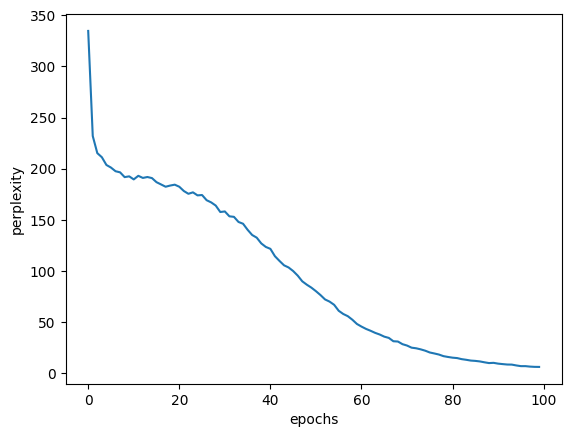

In [9]:
import sys
sys.path.append('..') # 为了导入父目录的模块
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 设定超参数
batch_size = 10 # 批量大小
wordvec_size = 100 # 词向量维度
hidden_size = 100 # 隐藏层维度
time_size = 5  # Truncated BPTT的时间跨度大小
lr = 0.1 # 学习率
max_epoch = 100 # 最大迭代轮数

# 读入训练数据（缩小了数据集）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000 # 仅使用1000个字符
corpus = corpus[:corpus_size] # 仅使用前1000个字符
vocab_size = int(max(corpus) + 1) # 词汇表大小

xs = corpus[:-1]  # 输入
ts = corpus[1:]  # 输出（监督标签）
data_size = len(xs) # 数据大小
print('语料库大小：%d，词汇表大小：%d' % (corpus_size, vocab_size))

# 学习用的参数
max_iters = data_size // (batch_size * time_size) # 每轮的迭代次数
time_idx = 0 # 时间索引
total_loss = 0 # 总损失
loss_count = 0 # 损失计数
ppl_list = [] # 困惑度列表

# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size) # 生成RNN语言模型
optimizer = SGD(lr) # 优化器

# step1：计算读入mini-batch的各笔样本数据的开始位置
jump = (corpus_size - 1) // batch_size # 每笔样本数据的间隔
offsets = [i * jump for i in range(batch_size)] # 各笔样本数据的开始位置列表，offsets的长度为batch_size

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # step2：获取mini-batch
        batch_x = np.empty((batch_size, time_size), dtype='i') # 初始化输入数据，维度为 (批量大小，时间步数)，(N, T)
        batch_t = np.empty((batch_size, time_size), dtype='i') # 初始化监督标签，维度为 (批量大小，时间步数)，(N, T)

        # 通过时间索引和开始位置，获取mini-batch
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # 填入输入数据，维度为 (N, T)，% data_size是为了循环取数据
                batch_t[i, t] = ts[(offset + time_idx) % data_size] # 填入监督标签，维度为 (N, T)，% data_size是为了循环取数据
            time_idx += 1

        # 计算梯度，更新参数
        loss = model.forward(batch_x, batch_t) # 前向传播计算损失
        model.backward() # 反向传播计算梯度
        optimizer.update(model.params, model.grads) # 更新参数
        total_loss += loss # 累积损失
        loss_count += 1 # 累积损失计数

    # step3：各个epoch的困惑度评价
    ppl = np.exp(total_loss / loss_count) # 计算困惑度
    print('| 轮次 %d | 困惑度 %.2f' % (epoch + 1, ppl)) # 输出当前轮次和困惑度
    ppl_list.append(float(ppl)) # 记录困惑度
    total_loss, loss_count = 0, 0 # 重置损失和计数

# 绘制图形
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

以上就是学习用的代码，这和我们之前看到的神经网络的学习基本上是一样的。不过，从宏观上看，仍有两点和之前的学习代码不同，即“数据的输入方式”和“困惑度的计算”。这里，我们将重点关注这两点，并对代码进行说明。

首先是数据的输入方式。这里我们使用 Truncated BPTT 进行学习，因此数据需要按顺序输入，并且 mini-batch 的各批次要平移读入数据的开始位置。在代码step1处，计算各批次读入数据的开始位置 `offsets`。`offsets` 的各个元素中存放了读入数据的开始位置（偏移量）。

接着，在代码step2处，按顺序读入数据。首先准备容器 `batch_x` 和 `batch_t`，然后依次增加 `time_idx` 变量，将 `time_idx` 处的数据从语料库中取出。这里利用step1中计算好的 `offsets`，各批次增加偏移量。另外，当读入语料库的位置超过语料库大小时，为了回到语料库的开头处，将当前位置除以语料库大小后的余数作为索引使用。

最后，基于式 (5.12) 计算困惑度，这在代码step3处完成。为了求每个 epoch 的困惑度，需要计算每个 epoch 的平均损失，然后再据此求困惑度。

以上就是对代码的说明，现在我们看一下学习结果。在上面的代码中，各个 epoch 的困惑度的结果都保存在了 `perplexity_list` 中，我们可以将它绘制出来，如下图 所示。

<img src="./fig/perplexity.png" alt="perplexity" style="display: block; margin: 0 auto;">

由图可知，随着学习的进行，困惑度稳步下降。一开始超过 300 的困惑度到最后接近 1（最小值）了。不过这里使用的是很小的语料库，在实际情况下，当语料库增大时，现在的模型根本无法招架。下一章我们将指出当前 RNNLM 存在的问题，并进行改进。

## RNNLM的Trainer类
本书提供了用于学习 RNNLM 的 `RnnlmTrainer` 类，其内部封装了刚才的 RNNLM 的学习。将刚才的学习代码重构为 `RnnlmTrainer` 类，结果如下。这里只摘录源代码的一部分。

```python
from common.trainer import RnnlmTrainer

# ...

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
```

如上所示，首先使用 `model` 和 `optimizer` 初始化 `RnnlmTrainer` 类，然后调用 `fit()`，完成学习。此时，`RnnlmTrainer` 类的内部将执行上一节进行的一系列操作，具体如下所示。

- 按顺序生成 mini-batch
- 调用模型的正向传播和反向传播
- 使用优化器更新权重
- 评价困惑度

<code>RnnlmTrainer</code>类与之前章节中介绍的<code>Trainer</code>类有相同的API。神经网络的常规学习使用<code>Trainer</code>类，而RNNLM的学习则使用<code>RnnlmTrainer</code>类。

使用 `RnnlmTrainer` 类，可以避免每次写重复的代码。本书的剩余部分都将使用 `RnnlmTrainer` 类学习 RNNLM。

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.12
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 357.79
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 248.00
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 215.52
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 205.46
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 205.19
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 199.03
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.30
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.26
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 189.34
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 191.91
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 189.27
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 192.02
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 187.74
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 187.17
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 191.23
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 188.80
| epoch 18 |  iter 1 / 

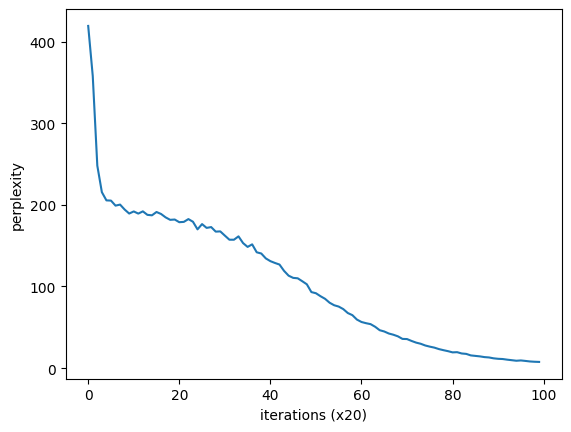

In [10]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 设定超参数
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN的隐藏状态向量的元素个数
time_size = 5  # RNN的展开大小
lr = 0.1
max_epoch = 100

# 读入训练数据
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 缩小测试用的数据集
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 输入
ts = corpus[1:]  # 输出（监督标签）

# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

## 小结
- RNN 具有环路，因此可以在内部记忆隐藏状态
- 通过展开 RNN 的循环，可以将其解释为多个 RNN 层连接起来的神经网络，可以通过常规的误差反向传播法进行学习（= BPTT）
- 在学习长时序数据时，要生成长度适中的数据块，进行以块为单位的 BPTT 学习（= Truncated BPTT）
- Truncated BPTT 只截断反向传播的连接
- 在 Truncated BPTT 中，为了维持正向传播的连接，需要按顺序输入数据
- 语言模型将单词序列解释为概率
- 理论上，使用 RNN 层的条件语言模型可以记忆所有已出现单词的信息